# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
'''添加fashion ai'''
fi_class_names=['neckline_left', 'neckline_right', 'center_front', 'shoulder_left', 
                'shoulder_right', 'armpit_left','armpit_right', 'waistline_left', 
                'waistline_right', 'cuff_left_in','cuff_left_out', 'cuff_right_in', 
                'cuff_right_out', 'top_hem_left','top_hem_right', 'waistband_left', 
                'waistband_right', 'hemline_left','hemline_right', 'crotch',
                'bottom_left_in', 'bottom_left_out','bottom_right_in', 'bottom_right_out']


Using TensorFlow backend.


In [47]:
class FIConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "FI"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 24  # background + 24 key_point

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    MASK_POOL_SIZE = 24
config = FIConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 24
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           FI
NUM_CLASSES                    25
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_POS

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



In [98]:
class FIDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    """参数:category决定数据类别为train validation test"""
        
    def load_FI(self,category):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        train_data_path='./data/train/'
        # Add classes
        for i,class_name in enumerate(fi_class_names):
            self.add_class("FI", i+1,class_name)
            
        annotations=pd.read_csv('./data/train/Annotations/annotations.csv')
        annotations=annotations.append(pd.read_csv('./data/train/Annotations/train.csv'),ignore_index=True)
        
        #切分test数据集和train数据集
        np.random.seed(42)
        shuffled_indces=np.random.permutation(annotations.shape[0])
        val_set_size=int(annotations.shape[0]*0.1)
        val_indices=shuffled_indces[:val_set_size]
        train_indices=shuffled_indces[val_set_size:]
        if category =='train':
            annotations=annotations.iloc[train_indices]
        elif category=='val':
            annotations=annotations.iloc[val_indices]
        else:
            #test 数据集
            pass
        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        
        annotations=annotations.reset_index(drop=True)#更新索引
        
        for x in range(annotations.shape[0]):
            #bg_color, shapes = self.random_image(height, width)
            id=annotations.loc[x,'image_id']
            category=annotations.loc[x,'image_category']
            
            im_path=os.path.join(train_data_path,id)
    
            height,width=cv2.imread(im_path).shape[0:2]
        
            key_points=[]
            for key_point in annotations.loc[x,fi_class_names].values:
                loc_cat=[int(j) for j in key_point.split('_')]
                key_points.append(loc_cat)
            
            self.add_image("Fi", image_id=id, path=im_path,
                           width=width, height=height,
                           key_points=key_points,image_category=category)#添加我的数据

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        根据image_id读取图片
        """
        info = self.image_info[image_id]
        image=cv2.imread(info['path'])
        return image

    def image_reference(self, image_id):
        """Return the key_points data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "FI":
            return info["key_points"],info["image_category"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        
        m = np.zeros([info['height'], info['width'], 24])#生成24个mask,因为有24个关键点。
        class_mask = np.zeros(24)  #点存在的状态经过处理有三种状态 不存在为0  1为不可见.2 为可见 三分类
        class_ids=[]
        key_points=np.array(info['key_points'])
        for part_num, bp in enumerate(key_points):
            if bp[2] > -1: #AI数据编码为bp[2]=1为可见，=2为不可见，=3为不在图内或者不可推测，FI编码为=-1为不存在，0为不可见，1为可见
                m[bp[1]-5:bp[1]+5, bp[0]-5:bp[0]+5, part_num] = 1
                class_mask[part_num] = bp[2]+1
                class_ids.append(part_num+1)
        if class_ids:
            mask = m[:,:,np.array(class_ids)-1]
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids, class_mask   
        else:
            return super(self.__class__).load_mask(image_id)
        '''shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask, class_ids.astype(np.int32)'''


In [99]:
# Training dataset
dataset_train = FIDataset()
dataset_train.load_FI(category='val')
dataset_train.prepare()
'''
# Validation dataset
dataset_val = FIDataset()
dataset_val.load_FI(category='val')
dataset_val.prepare()
'''

"\n# Validation dataset\ndataset_val = FIDataset()\ndataset_val.load_FI(category='val')\ndataset_val.prepare()\n"

In [107]:
'''显示image和mask'''
def display_top_masks(image, mask, class_ids, class_names, limit=5):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    
    ###
    mask_area=np.ones(len(class_ids))
    ###
                      
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    print("top_ids",top_ids)
    # Generate images and titles
    sd=np.array(top_ids).reshape(-1,1)
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    visualize.display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")

mask_shape: (409, 512, 12)
class_ids [ 1  2  4  5  6  7 10 11 12 13 14 15]
top_ids [1, 2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15]


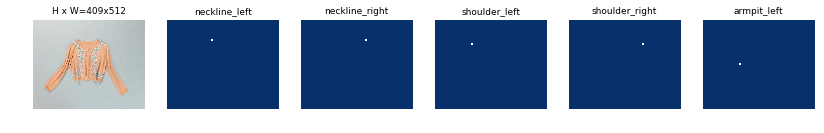

mask_shape: (512, 512, 4)
class_ids [16 17 18 19]
top_ids [16, 17, 18, 19]


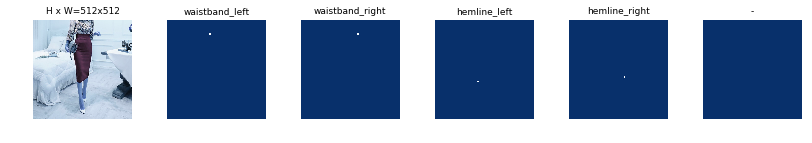

mask_shape: (500, 500, 4)
class_ids [16 17 18 19]
top_ids [16, 17, 18, 19]


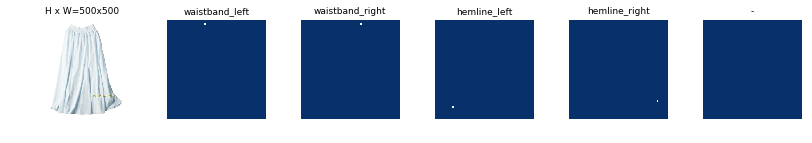

mask_shape: (512, 512, 13)
class_ids [ 1  2  3  4  5  6  7 10 11 12 13 14 15]
top_ids [1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15]


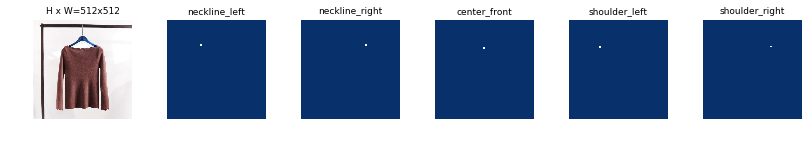

mask_shape: (512, 512, 13)
class_ids [ 1  2  3  4  5  6  7 10 11 12 13 14 15]
top_ids [1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15]


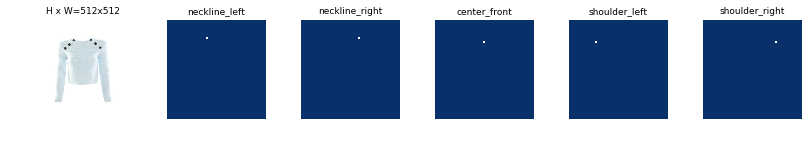

mask_shape: (512, 384, 13)
class_ids [ 1  2  3  4  5  6  7 10 11 12 13 14 15]
top_ids [1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15]


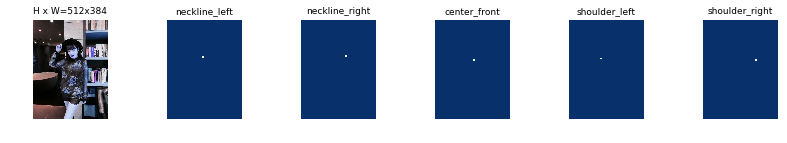

mask_shape: (512, 512, 3)
class_ids [16 17 18]
top_ids [16, 17, 18]


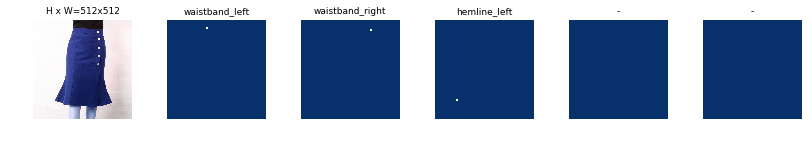

mask_shape: (512, 512, 12)
class_ids [ 1  2  4  5  6  7 10 11 12 13 14 15]
top_ids [1, 2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15]


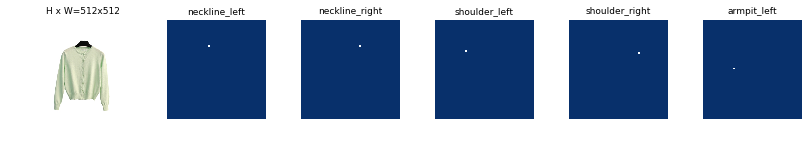

mask_shape: (460, 460, 12)
class_ids [ 1  2  4  5  6  7 10 11 12 13 14 15]
top_ids [1, 2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15]


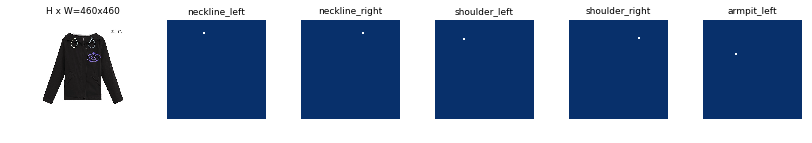

mask_shape: (512, 512, 13)
class_ids [ 1  2  3  4  5  6  7 10 11 12 13 14 15]
top_ids [1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15]


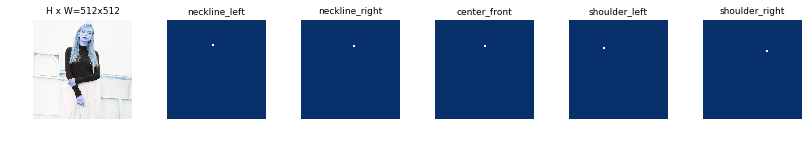

In [108]:
# Load and display random samples
np.random.seed(78)
image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids,_ = dataset_train.load_mask(image_id)
    print('mask_shape:',mask.shape)
    print('class_ids',class_ids)
    display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [109]:
def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    figsize: (optional) the size of the image.
    """
    # Number of instances
    N = boxes.shape[0]
    print("box shape:",boxes.shape[0])
    print("mask shape:",masks.shape[-1])
    print(class_ids.shape[0])
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)

        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    plt.show()

image                    shape: (512, 341, 3)         min:    0.00000  max:  255.00000
mask                     shape: (512, 341, 12)        min:    0.00000  max:    1.00000
class_ids                shape: (12,)                 min:    1.00000  max:   15.00000
bbox                     shape: (12, 4)               min:   83.00000  max:  262.00000


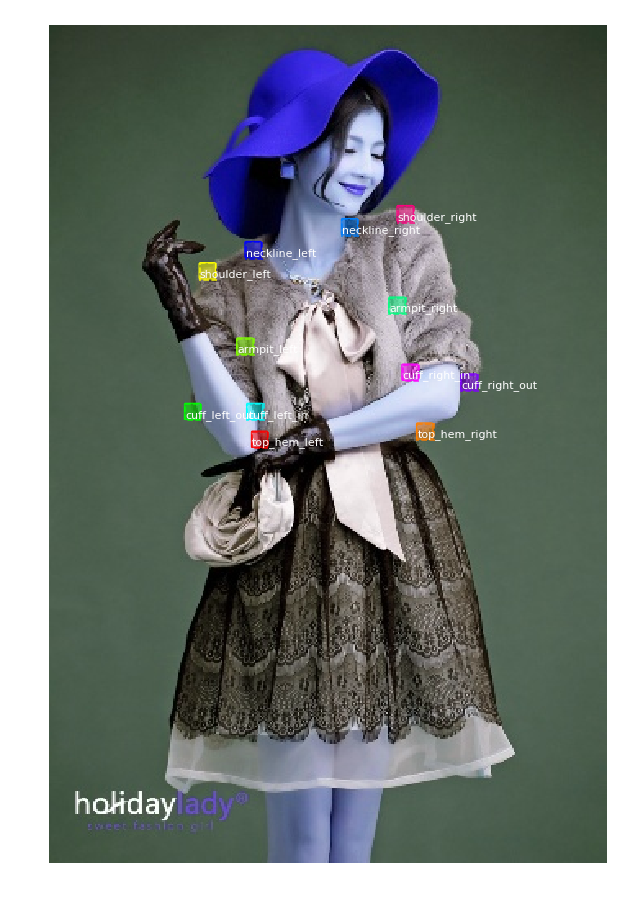

In [110]:
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids,_ = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
#print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

In [89]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)